In [1]:
import numpy as np
from matplotlib import pyplot as plt, animation as animation, ticker as mticker
from matplotlib.pyplot import cm
import pandas as pd
from tqdm.notebook import tqdm

from fireworks.particles import Particles
import fireworks.nbodylib.nunits as NU
import fireworks.nbodylib.potentials as fnp
import fireworks.nbodylib.dynamics as fnd
import fireworks.nbodylib.integrators as fni

# Initial conditions of the system
This will also effect the name of .gif the file that are saved 

In [74]:
N = 5000
initial_position = 20   #pos del 
M_G = 1e3               # mass of the galaxy

Shifting in phase space to be in circular orbit 

Move to Center of mass reference frame: 
 pos Center of Mass: [-2.60208521e-18 -7.37257477e-18  3.46944695e-18] vel Center of Mass [8.67361738e-18 3.46944695e-18 5.20417043e-18]
Move Center of mass to x=5, y=z=0: 
 pos Center of Mass: [ 2.00000000e+01 -7.37257477e-18  3.46944695e-18] vel Center of Mass [8.67361738e-18 3.46944695e-18 5.20417043e-18]
Give Center of Mass to vel_x=vel_z=0, vel_y=sqrt(M_G/x): 
 pos Center of Mass: [ 2.00000000e+01 -7.37257477e-18  3.46944695e-18] vel Center of Mass [8.67361738e-18 7.07106781e+00 5.20417043e-18]


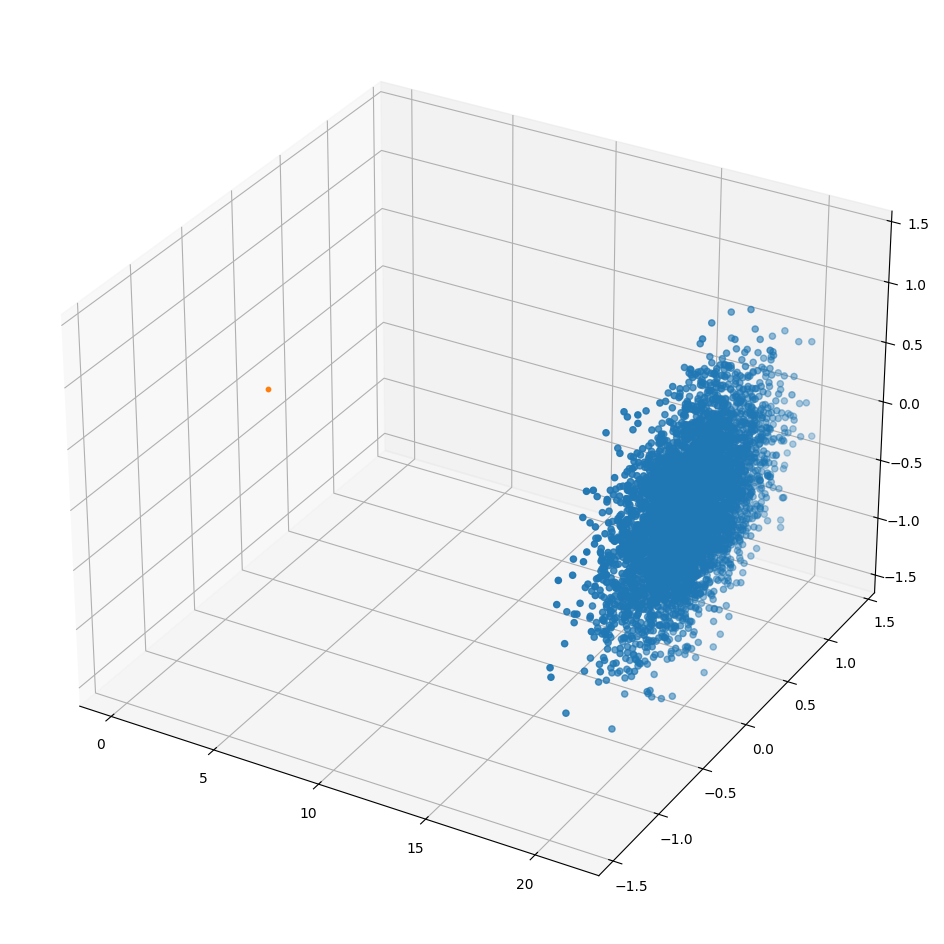

In [3]:
# the Particles are already in Henon units, so in Nbody units
path = 'Data/Plummer_Nbody_virial_' + str(N) + '.csv'
data = pd.read_csv(path).values
particles = Particles(position= data[:, 4:],  velocity = data[:, 1:4], mass = data[:, 0])


# move the stars in the frame of reference of the center of mass
particles.pos = particles.pos - particles.com_pos()
particles.vel = particles.vel - particles.com_vel()
print('Move to Center of mass reference frame:', '\n', 'pos Center of Mass:', particles.com_pos(), 'vel Center of Mass', particles.com_vel())

# move the stars in circular orbit 
particles.pos[:, 0] = particles.pos[:, 0] + initial_position*np.ones(len(particles))
print('Move Center of mass to x=5, y=z=0:', '\n', 'pos Center of Mass:', particles.com_pos(), 'vel Center of Mass', particles.com_vel())

particles.vel[:, 1] = particles.vel[:, 1] + np.sqrt(M_G / particles.com_pos()[0]) 
print('Give Center of Mass to vel_x=vel_z=0, vel_y=sqrt(M_G/x):', '\n', 'pos Center of Mass:', particles.com_pos(), 'vel Center of Mass', particles.com_vel())

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(xs = particles.pos[:, 0], ys = particles.pos[:, 1], zs = particles.pos[:, 2])
ax.scatter(xs = 0, ys = 0, zs = 0, s=10)

# Orbit Integration using PointMass Potential 
Softening is used to avoid the PointMass singularity. The evolution is performed using pyfalcon as acc estimator, leapfrog as integrator

  0%|          | 0/889 [00:00<?, ?it/s]

Text(0.5, 0.92, 'Final Shapshot')

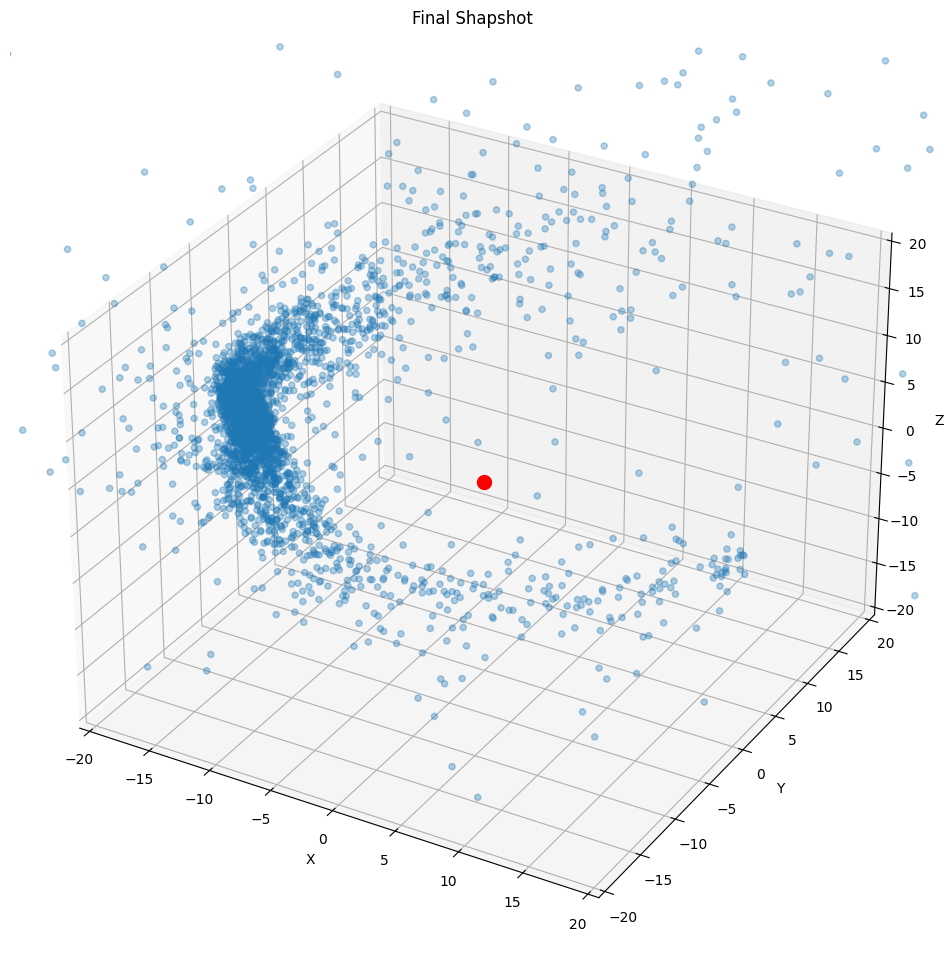

In [4]:
#Potential 
#calculate mean distance to get the softening foir the Point_Mass potential
mean_distance = np.zeros((N, N)) 
for i in range(2):
    mean_distance += (particles.pos[:, i] - particles.pos[:, i].reshape(N, 1))**2
mean_distance = (np.sqrt(mean_distance[mean_distance != 0.0])).mean()

potential_PointMass = fnp.Point_Mass(Mass=M_G, softening = mean_distance) 

#time of integration
orbital_period = 2*np.pi*np.sqrt(initial_position**3/M_G)/4 #time given by 2*orbit_time
tstep = 0.01 
time = np.arange(0, 2*orbital_period, tstep)

#list for analysys
pos_list, pos_com_list, vel_list, vel_com_list, energy_list = [particles.pos], [particles.com_pos()], [particles.vel], [particles.com_vel()], [particles.Etot]

for dt in tqdm(time):
    acc_PointMass = potential_PointMass.acceleration
    particles, _, _, _, _ = fni.integrator_leapfrog(particles=particles, tstep=tstep, acceleration_estimator=fnd.acceleration_pyfalcon, external_accelerations=[potential_PointMass.acceleration])
    #saving important quantities for analysis of the dynamics
    pos_list.append(particles.pos.copy())
    pos_com_list.append(particles.com_pos())
    vel_list.append(particles.vel.copy())
    vel_com_list.append(particles.com_vel())
    Etot, _, _ = particles.Etot()
    energy_list.append(Etot)
    
pos_array = np.array(pos_list)
pos_com_array = np.array(pos_com_list)
vel_array = np.array(vel_list)
vel_com_array = np.array(vel_com_list)
energy_array = np.array(energy_list)

#save
array_to_save = np.zeros((len(pos_array), N, 7))
array_to_save[:, :, :3], array_to_save[:, :, 3:6], array_to_save[:, :, 6] = pos_array, vel_array, (1/N)*np.ones_like(array_to_save[:, :, 6])
np.save(file=f'Orbit/Galactic_FoR/{N}_InitialPos_{initial_position}', arr=array_to_save)

#plot final Snaphot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(xs = particles.pos[:, 0], ys = particles.pos[:, 1], zs = particles.pos[:, 2])
ax.scatter(xs = 0, ys = 0, zs = 0, s=100, c='r')
ax.set_xlim(-initial_position, initial_position)
ax.set_ylim(-initial_position, initial_position)
ax.set_zlim(-initial_position, initial_position)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Final Shapshot')

## Movie gif

Starting Position Animation: 5000_InitialPos_20.gif 
Position Animation Saved: 5000_InitialPos_20.gif


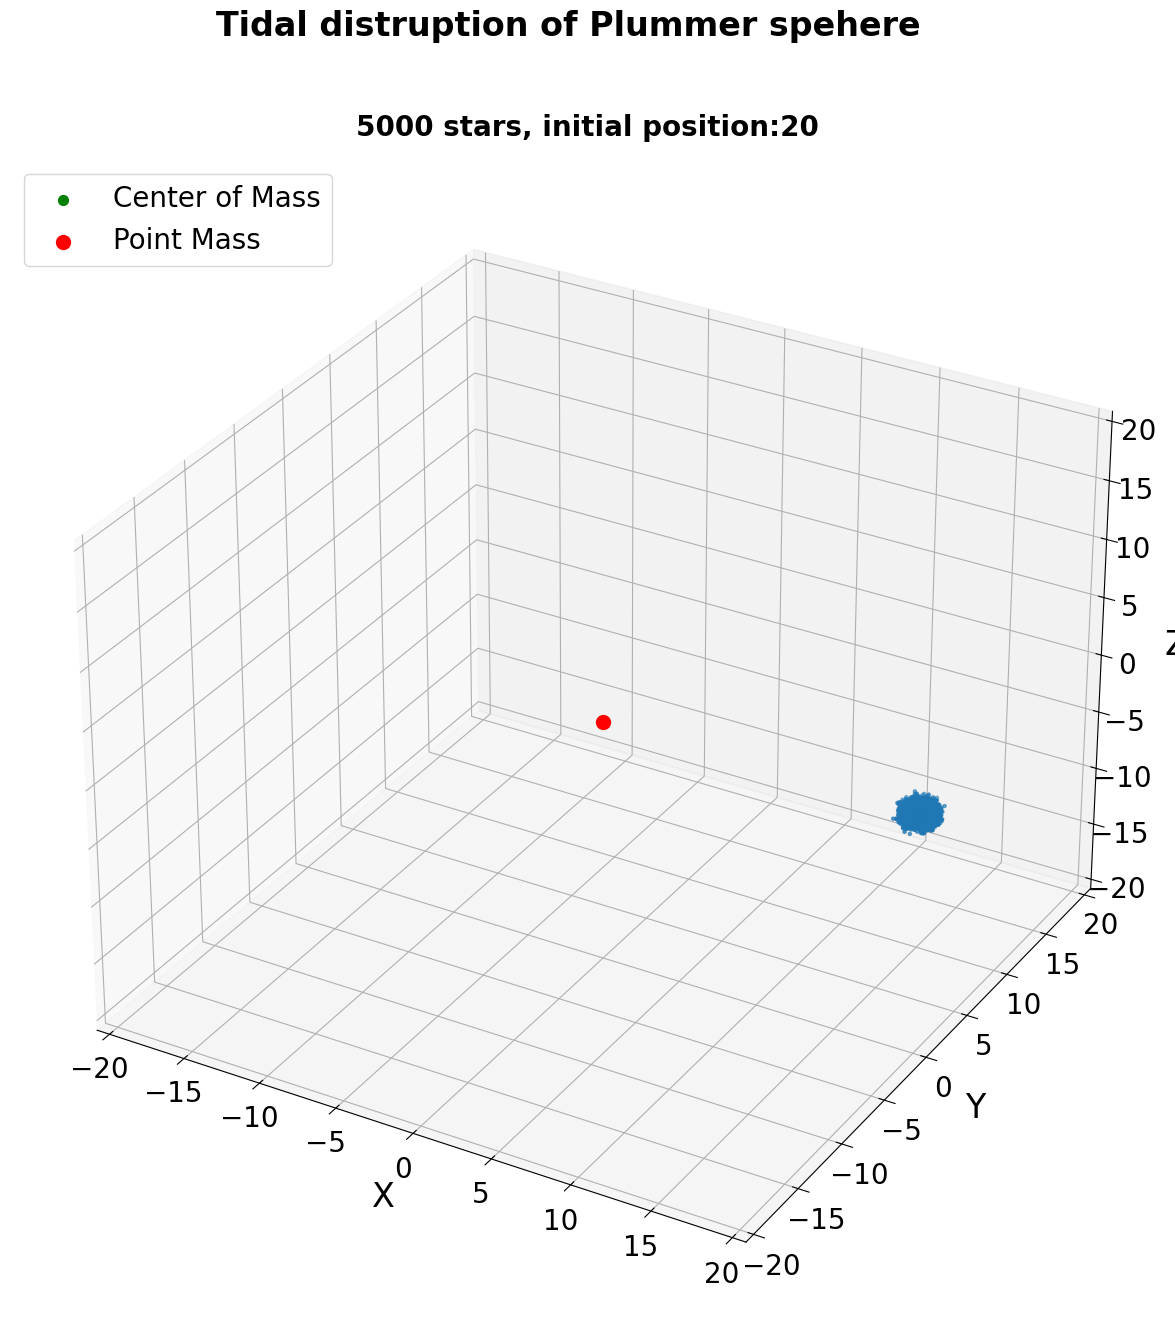

In [6]:
### downsampling
m = 1

pos_array_plot = pos_array.copy()[::m] #the copy is useful to not overwrite pos_array (otherwise you would need to rerun the integration, we don't want that)
pos_com_array_plot = pos_com_array.copy()[::m]

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
plt.rcParams['font.size'] = '16'
plt.rcParams['lines.linewidth'] = '4'
plt.rcParams['axes.titlesize'] = '20'
plt.rcParams['axes.titlepad'] = '17'
plt.rcParams['axes.labelsize'] = '24'
plt.rcParams['legend.fontsize'] = '20'
plt.rcParams['axes.labelpad'] = '12'
plt.rcParams['axes.titleweight'] = '600'
plt.rcParams['axes.labelweight'] = '500'
plt.rcParams['xtick.labelsize'] = '20'
plt.rcParams['ytick.labelsize'] = '20'
plt.rcParams['xtick.major.size'] = '10'
plt.rcParams['ytick.major.size'] = '10'
plt.rcParams['ytick.minor.size'] = '4'

# Calculate the number of extra frames to add at the beginning and the end
pause_duration = 5  # pause duration in seconds start
pause_duration_end = 1  # pause duration in seconds end
frame_rate = 15  # frame rate of the animation
extra_frames = pause_duration * frame_rate
extra_frames_end = pause_duration_end * frame_rate

# Create an array of frame indices
frames = np.concatenate([
    np.full(int(extra_frames), 0),  # initial frame (pause
    np.arange(0, len(pos_array_plot[:])-1, 2),  # original frames
    np.full(int(extra_frames_end), len(pos_array_plot[:])-2)  # extra frames at the end
])


ax.scatter(pos_array_plot[0][:, 0],pos_array_plot[0][:, 1], pos_array_plot[0][:, 2], s=5)
ax.scatter(pos_com_array_plot[0, 0], pos_com_array_plot[0, 1], pos_com_array_plot[0, 2], s=50, c='g', label='Center of Mass')
ax.scatter(xs = 0, ys = 0, zs = 0, s=100, c='r', label='Point Mass')
ax.set_xlim(-initial_position, initial_position)
ax.set_ylim(-initial_position, initial_position)
ax.set_zlim(-initial_position, initial_position)
ax.set_title(f'{N} stars, initial position:{initial_position}')
ax.legend(loc='upper left')


def update_pos(frame): 
    ax.clear()
    
    ax.scatter(pos_array_plot[frame][:, 0],pos_array_plot[frame][:, 1], pos_array_plot[frame][:, 2], s=5)
    ax.scatter(pos_com_array_plot[frame, 0], pos_com_array_plot[frame, 1], pos_com_array_plot[frame, 2], s=50, c='g', label='Center of Mass')
    ax.scatter(xs = 0, ys = 0, zs = 0, s=100, c='r', label='Point Mass')
    ax.set_xlim(-initial_position, initial_position)
    ax.set_ylim(-initial_position, initial_position)
    ax.set_zlim(-initial_position, initial_position)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'{N} stars, initial position:{initial_position}')
    ax.legend(loc='upper left')
    
    fig.suptitle(f'Tidal distruption of Plummer spehere', 
                 fontsize=24, fontweight='600')

print(f"Starting Position Animation: {N}_InitialPos_{initial_position}.gif ")

gif_pos = animation.FuncAnimation(fig=fig, func=update_pos, frames=frames, interval=10)
gif_pos.save(f"./gif/Galaxy_FoR/{N}_InitialPos_{initial_position}.gif", writer="pillow")

print(f"Position Animation Saved: {N}_InitialPos_{initial_position}.gif")

# Analysis 

- Radii containing a given amount of mass: usually the half-mass
radius, , i.e. the radius containing half of the total mass of the
systems is used a characteristic length of the system. Following its
evolution is possible to understand if the systems is in equilibrium (
approximately constant) or not (e.g., grows if the systems is
expanding). Combining multiple radii (e.g the one contains 10% of the
mass, the half-mass radius and the radius containing the 90% of the
mass) is possible to investigate if the system is evolving in a
homologous way or if there are decoupled regions (i.e. the inner region
is collapsing while the outer region is expanding, see e.g. Lecture 2B).
- Density profile: in order to have a more detailed view of the mass
distribution, the complete 3D density profile can be obtained as follows.
Bin the particles as a function of the spherical radius r, then sum all the
masses of the particles to obtain , finally the area of the
spherical shell is $$V_{shell} = \frac{4}{3}\pi (r_{outer}^3 - r_{inner}^3),$$ where $r_{outer}$ and $r_{inner}$
are the edges of the considered bin. Finally .
You can check how the density profile change as a function of time
during the simulation.
- Kinematics: the velocity dispersion can be used as a measure of the
kinematic status of the systems. You can replicate the above analysis
estimating the velocity dispersion within a given radius (i.e. the half-
mass radius) or estimate the radial trend of the velocity dispersion
binning the particles in spherical shells.

*Notice*: the characteristic radii and the profiles need to be estimated
considering the radius with respect to the centre of mass of the systems.
Since this can evolve during the evolution (because of some initial small
stochastic asymmetry in the initial particle distribution) remember to rescale
the position and velocities of particles by the centre of mass and centre of
mass velocity when analysis the simulation snapshots

*Notice-2*: when the mass loss starts to be significant the centre of mass
could be not centred in the density peak of the system. How could you find
the density peak of the system?

In [5]:
#Shift in the frame of reference of CoM
position_comFoR = np.ones_like(pos_array)
velocity_comFoR = np.ones_like(vel_array)
for i in range(len(pos_com_array)): #for every Snapshot
    for j in range(3):              #for x, y, z
        position_comFoR[i][:, j] = pos_array[i][:, j] - pos_com_array[i, j] #probably it can be done with numpy array brodcast           
        velocity_comFoR[i][:, j] = vel_array[i][:, j] - vel_com_array[i, j] #probably it can be done with numpy array brodcast      

#save the com Frame of reference
array_to_save = np.zeros((len(position_comFoR), N, 7))
array_to_save[:, :, :3], array_to_save[:, :, 3:6], array_to_save[:, :, 6] = position_comFoR, velocity_comFoR, (1/N)*np.ones_like(array_to_save[:, :, 6])
np.save(file=f'Orbit/Cluster_FoR/{N}_InitialPos_{initial_position}', arr=array_to_save)

## Movie gif FoR (Frame of Reference) Center of Mass

Starting Position Animation: FoR_5000_InitialPos_20.gif 
Position Animation Saved: FoR_5000_InitialPos_20.gif


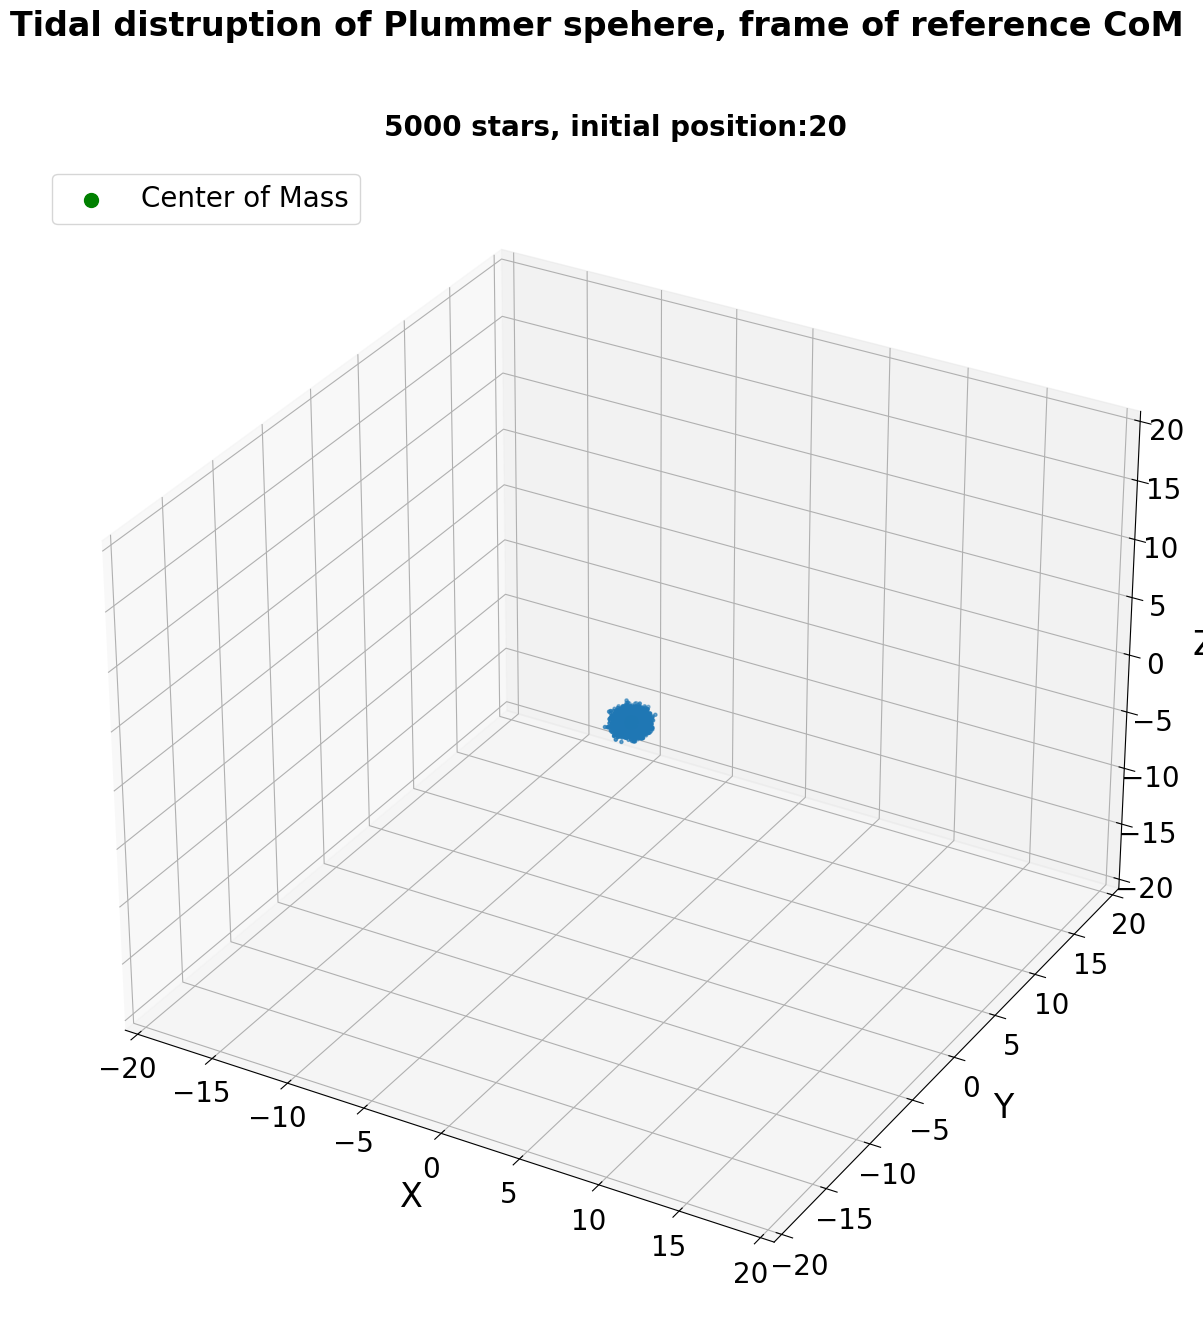

In [8]:
# downsampling
m = 1

pos_array_plot = position_comFoR.copy()[::m] #the copy is useful to not overwrite pos_array (otherwise you would need to rerun the integration, we don't want that)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
plt.rcParams['font.size'] = '16'
plt.rcParams['lines.linewidth'] = '4'
plt.rcParams['axes.titlesize'] = '20'
plt.rcParams['axes.titlepad'] = '17'
plt.rcParams['axes.labelsize'] = '24'
plt.rcParams['legend.fontsize'] = '20'
plt.rcParams['axes.labelpad'] = '12'
plt.rcParams['axes.titleweight'] = '600'
plt.rcParams['axes.labelweight'] = '500'
plt.rcParams['xtick.labelsize'] = '20'
plt.rcParams['ytick.labelsize'] = '20'
plt.rcParams['xtick.major.size'] = '10'
plt.rcParams['ytick.major.size'] = '10'
plt.rcParams['ytick.minor.size'] = '4'

# Calculate the number of extra frames to add at the beginning and the end
pause_duration = 5  # pause duration in seconds start
pause_duration_end = 1  # pause duration in seconds end
frame_rate = 15  # frame rate of the animation
extra_frames = pause_duration * frame_rate
extra_frames_end = pause_duration_end * frame_rate

# Create an array of frame indices
frames = np.concatenate([
    np.full(int(extra_frames), 0),  # initial frame (pause
    np.arange(0, len(pos_array_plot[:])-1, 2),  # original frames
    np.full(int(extra_frames_end), len(pos_array_plot[:])-2)  # extra frames at the end
])



ax.scatter(pos_array_plot[0][:, 0], pos_array_plot[0][:, 1], pos_array_plot[0][:, 2], s=5)
ax.scatter(0, 0, 0, s=100, c='g', label='Center of Mass')

# ax.scatter(xs = 0, ys = 0, zs = 0, s=100)
ax.set_xlim(-initial_position, initial_position )
ax.set_ylim(-initial_position, initial_position )
ax.set_zlim(-initial_position, initial_position )
ax.set_title(f'{N} stars, initial position:{initial_position}')
ax.legend(loc='upper left')


def update_pos(frame): 
    ax.clear()
    
    ax.scatter(pos_array_plot[frame][:, 0],pos_array_plot[frame][:, 1], pos_array_plot[frame][:, 2], s=5)
    ax.scatter(0, 0, 0, s=100, c='g', label='Center of Mass')
    # ax.scatter(xs = 0, ys = 0, zs = 0, s=100)

    ax.set_xlim(-initial_position, initial_position )
    ax.set_ylim(-initial_position, initial_position )
    ax.set_zlim(-initial_position, initial_position )

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'{N} stars, initial position:{initial_position}')
    ax.legend(loc='upper left')
    
    fig.suptitle(f'Tidal distruption of Plummer spehere, frame of reference CoM', 
                 fontsize=24, fontweight='600')

print(f"Starting Position Animation: FoR_{N}_InitialPos_{initial_position}.gif ")

gif_pos = animation.FuncAnimation(fig=fig, func=update_pos, frames=frames, interval=10)
gif_pos.save(f"./gif/Cluster_FoR/FoR_{N}_InitialPos_{initial_position}.gif", writer="pillow")

print(f"Position Animation Saved: FoR_{N}_InitialPos_{initial_position}.gif")

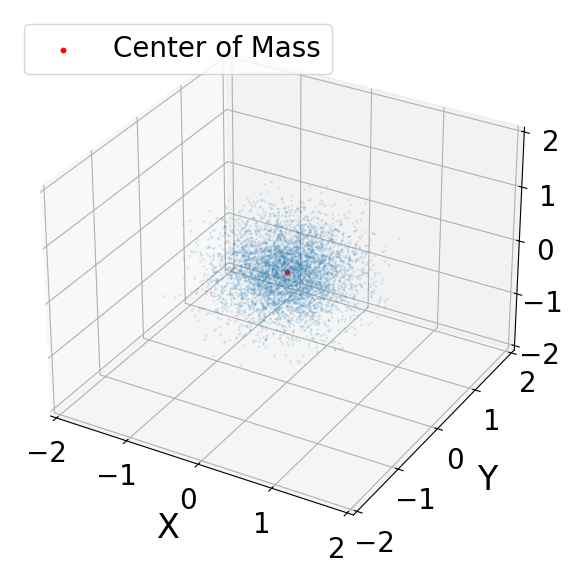

In [85]:
def plot_comFOR_scatter(positions):
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(0,0,0, s=10, c='r', label='Center of Mass')
    ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], s=1, alpha=0.1)

    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend(loc='upper left')

pos = position_comFoR[0]
plot_comFOR_scatter(pos)

## %_mass_radius

Text(0, 0.5, 'Radius [Henon unit]')

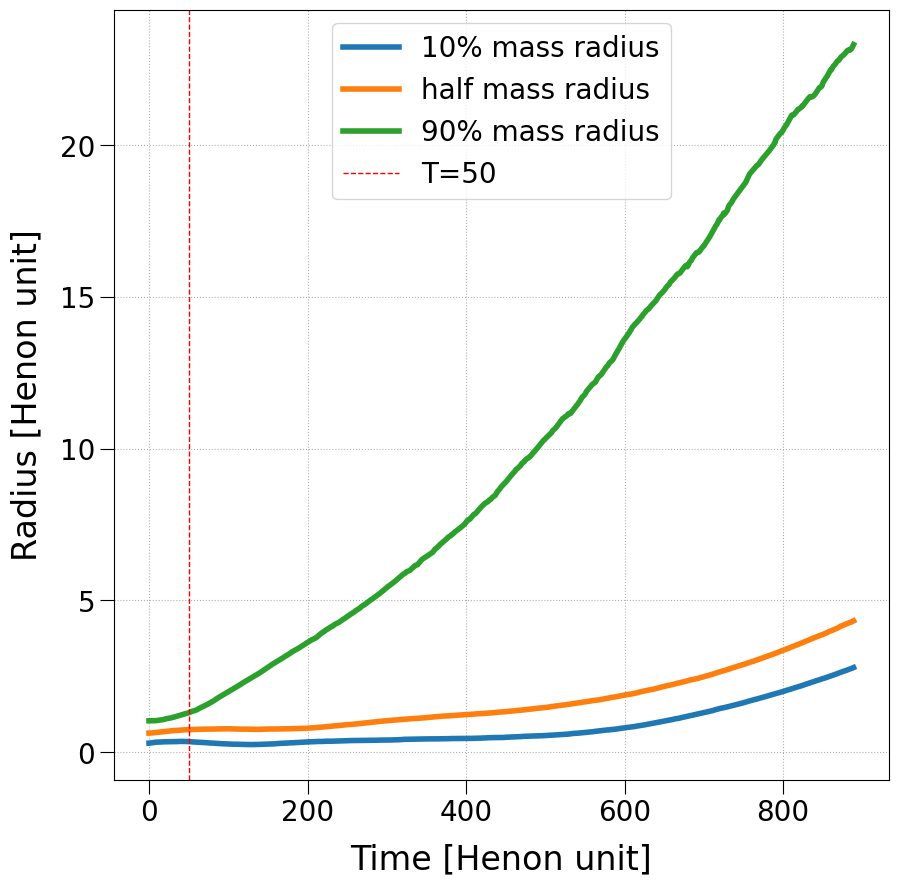

In [93]:
tenperc_mass_radius = []
half_mass_radius = []
ninethyperc_mass_radius = []

for i in range(int(len(position_comFoR))):
    current_radius = np.linalg.norm(position_comFoR[i], axis=1)
    sorted_radius = sorted(current_radius)
    tenperc_mass_radius.append(sorted_radius[int(N/10)])
    half_mass_radius.append(sorted_radius[int(N/2)])
    ninethyperc_mass_radius.append(sorted_radius[int(9*N/10)])
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.plot(tenperc_mass_radius, label='10% mass radius')
ax.plot(half_mass_radius, label='half mass radius')
ax.plot(ninethyperc_mass_radius, label='90% mass radius')
ax.axvline(x=50, linestyle='--', c='r', linewidth=1, label='T=50')

ax.legend()
ax.grid(linestyle='dotted')
ax.set_xlabel('Time [Henon unit]')
ax.set_ylabel('Radius [Henon unit]')

## Density profile 

Text(0.5, 1.0, 'Time: 2')

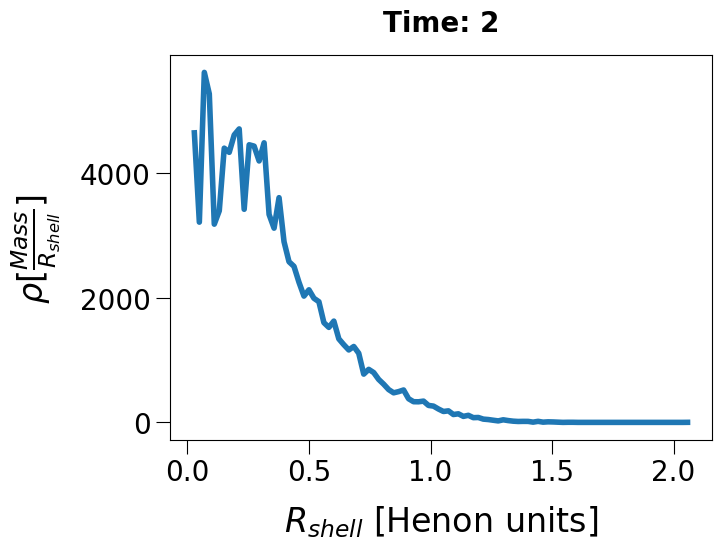

In [125]:
time = 2
pos_snapshot = position_comFoR[time]
radius_snapshot = np.linalg.norm(pos_snapshot, axis=1)
counts, bin_edges = np.histogram(radius_snapshot, bins=100)
Vol_shell = 4/3 *np.pi* (bin_edges[1:]**3 - bin_edges[:-1]**3)
density = counts / Vol_shell
radius_Shell = 1/2 * (bin_edges[1:] + bin_edges[:-1])

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot()
ax.plot(radius_Shell, density)
ax.set_xlabel(r'$R_{shell}$ [Henon units]')
ax.set_ylabel(r'$\rho [\frac{Mass}{R_{shell}}]$ ')
ax.set_title(f'Time: {time}')

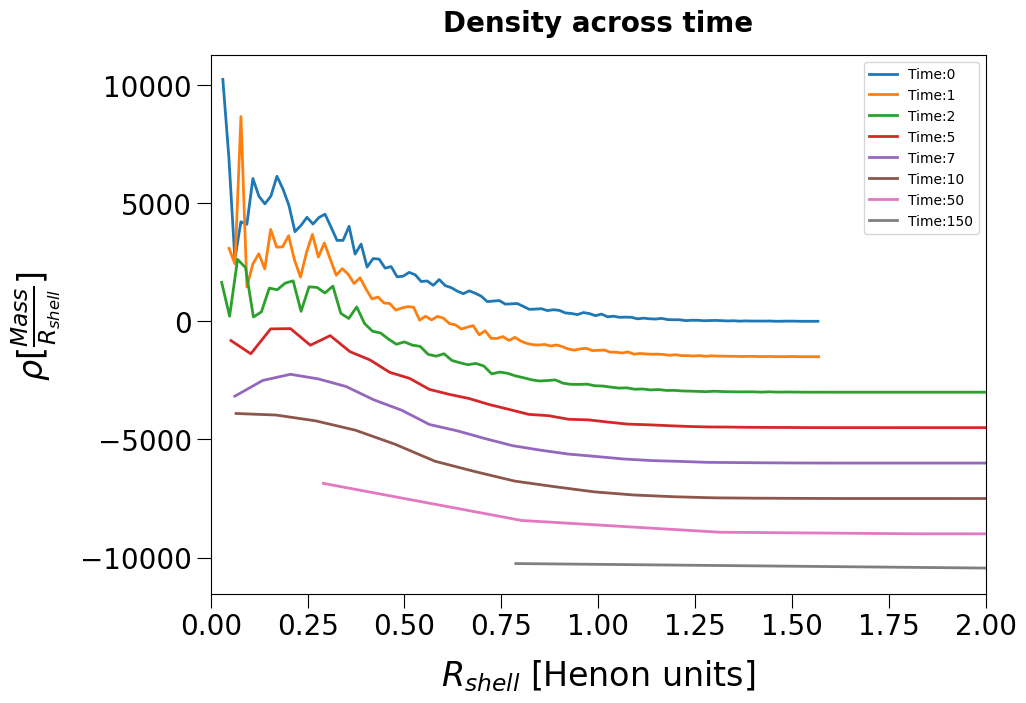

In [148]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot()
for k, time in enumerate([0, 1, 2, 5, 7, 10, 50, 150]):
    pos_snapshot = position_comFoR[time]
    radius_snapshot = np.linalg.norm(pos_snapshot, axis=1)
    counts, bin_edges = np.histogram(radius_snapshot, bins=100)
    Vol_shell = 4/3 *np.pi* (bin_edges[1:]**3 - bin_edges[:-1]**3)
    density = counts / Vol_shell
    radius_Shell = 1/2 * (bin_edges[1:] + bin_edges[:-1])
    
    ax.plot(radius_Shell, density-1500*k, label=f'Time:{time}', linewidth=2)
    ax.set_xlabel(r'$R_{shell}$ [Henon units]')
    ax.set_ylabel(r'$\rho [\frac{Mass}{R_{shell}}]$ ')
    ax.set_xlim(0, 2)
    ax.legend(loc='upper right', fontsize=10)
    ax.set_title(f'Density across time')